In [1]:
import numpy as np, requests, pandas as pd, time, zipfile, StringIO

In [2]:
heads={'Albania':'Prime Minister Edi Rama',
'Algeria':'Foreign Minister Ramtane Lamamra',
'Austria':'Foreign Minister Sebastian Kurz',
'Belgium':'Prime Minister Charles Michel',
'Benin':'President Thomas Boni Yayi',
'United Kingdom':'Prime Minister David Cameron',
'Bulgaria':'Prime Minister Boyko Borisov',
'Canada':'Public Safety Minister Steven Blaney',
'Croatia':'Prime Minister Zoran Milanovic',
'Czech Republic':'Prime Minister Bohuslav Sobotka',
'Denmark':'Prime Minister Helle Thorning-Schmidt',
'Gabon':'President Ali Bongo Ondimba',
'Georgia':'Prime Minister Irakli Garibashvili',
'Germany':'Chancellor Angela Merkel',
'Greece':'Prime Minister Antonis Samaras',
'Hungary':'Prime Minister Viktor Orban',
'Israel':'Prime Minister Benjamin Netanyahu and Foreign Minister Avigdor Lieberman',
'Italy':'Prime Minister Matteo Renzi',
'Jordan':'King Abdullah II and Queen Rania',
'Latvia':'Prime Minister Laimdota Straujuma',
'Mali':'President Ibrahim Boubacar Keita',
'Niger':'President Mahamadou Issoufou',
'Palestine':'president Mahmud Abbas',
'Portugal':'Prime Minister Pedro Passos Coelho',
'Romania':'President Klaus Iohannis',
'Russia':'Foreign Minister Sergei Lavrov',
'Spain':'Prime Minister Mariano Rajoy',
'Switzerland':'President Simonetta Sommaruga',
'Netherlands':'Prime Minister Mark Rutte',
'Tunisia':'Prime Minister Mehdi Jomaa',
'Turkey':'Prime Minister Ahmet Davutoglu',
'United Arab Emirates':'Foreign Minister Sheikh Abdullah bin Zayed al-Nahayan',
'Ukraine':'President Petro Poroshenko',
'United States':'Attorney General Eric Holder',
'Bahrain': 'Foreign Minister Sheikh Khaled ben Ahmed Al Khalifa and Prince Abdullah Ben Hamad al-Khalifa',
'Qatar': 'Sheikh Mohamed Ben Hamad Ben Khalifa Al Thani',
'Norway':'Prime Minister Erna Solberg',
'Kosovo': 'President Atifete Jahjaga',
'Poland':'Prime Minister Ewa Kopacz',
'Ireland':'Prime Minister Enda Kenny',
'Slovakia':'Prime Minister Robert Fico',
'Luxembourg':'Prime Minister Xavier Bettel',
'Malta':'Prime Minister Joseph Muscat',
'Slovenia':'Prime Minister Miro Cerar',
'Sweden':'Prime Minister Stefan Lofven',
'Finland':'Prime Minister Alexander Stubb'}

In [4]:
codes=pd.read_html('http://www.geonames.org/countries/',header=0,infer_types=False)[1]
codes.columns=['ISO2','ISO3','ISONUM','FIPS','Country','Capital','Area','Population','Continent']
codes.set_index('Country',drop=True,inplace=True)
codes.head(5)

C:\Program Files\Anaconda\lib\site-packages\pandas\io\html.py:841: FutureWarning: infer_types will have no effect in 0.14
  warnings.warn("infer_types will have no effect in 0.14", FutureWarning)


,ISO2,ISO3,ISONUM,FIPS,Capital,Area,Population,Continent
Country,,,,,,,,
Andorra,AD,AND,20,AN,Andorra la Vella,468.0,84000,EU
United Arab Emirates,AE,ARE,784,AE,Abu Dhabi,82880.0,4975593,AS
Afghanistan,AF,AFG,4,AF,Kabul,647500.0,29121286,AS
Antigua and Barbuda,AG,ATG,28,AC,St. John's,443.0,86754,nan
Anguilla,AI,AIA,660,AV,The Valley,102.0,13254,nan


In [37]:
a={}
#for i in heads: #only visitor countries
for i in codes.index: #all countries
    try: a[i]={'code':codes.loc[i]['ISO3']}
    except: print i
a.pop('nan')

{'code': Country
 nan        ANT
 nan        SCG
 Name: ISO3, dtype: object}

In [164]:
for i in a: #all countries
    if i in heads:
        a[i]['head']=True
    else: a[i]['head']=False

In [34]:
def cc(country): #country name converters
    if '(' in country: return country[0:country.find('(')-1]
    elif country=="Macao": return "Macau"
    elif country=="Republic of the Congo": return "Congo, Republic of the"
    elif country=="East Timor": return "Timor-Leste"
    elif country==u"RÃ©union": return u"Réunion"
    elif country==u"SÃ£o TomÃ© and PrÃ­ncipe": return "Sao Tome and Principe"
    elif country=="Gambia": return "The Gambia"
    elif country=="Democratic Republic of the Congo": return "Congo, Democratic Republic of the"
    elif country=="Myanmar [Burma]": return "Burma"
    else: return country

def cc2(country):
    if country=="Montenegro": return "Montenegro[d]"
    elif country=="Kosovo": return "Kosovo[e]"
    elif country=="Serbia": return "Serbia[d]"
    elif country=="Cyprus": return "Cyprus[b]"
    elif country=="United States": return "United States[c]"
    elif country=="Israel": return "Israel[c]"
    elif country=="East Timor": return "Timor-Leste"
    elif country=="Myanmar [Burma]": return "Burma"
    else: return country
    
def cc3(country):
    if country=="Palestine": return "West Bank"
    elif country=="Ivory Coast": return "Cote d'Ivoire"
    elif country=="East Timor": return "Timor-Leste"
    elif country=="Myanmar [Burma]": return "Burma"
    else: return country

In [10]:
rel=pd.read_html('http://en.wikipedia.org/wiki/Religions_by_country')[1][1:].drop([1,2,3,4,6]+range(8,20),axis=1)
rel.columns=['Country','Christian','Muslim']
rel=rel.set_index('Country',drop=True)
rel.index=[cc(i) for i in rel.index]
rel.head()

,Christian,Muslim
Burundi,91.50 %,2.80 %
Comoros,0.50 %,98.30 %
Djibouti,2.30 %,96.90 %
Eritrea,62.90 %,36.60 %
Ethiopia,62.80 %,34.60 %


In [15]:
bad=[]
for i in a:
    try: 
        for j in ['Christian','Muslim']:
            c=rel.loc[cc(i)][j]
            c=c[0:c.find('%')-1]
            a[i][j]=float(c)
    except: 
        bad.append(i)
        print i
for i in bad: a.pop(i)

In [17]:
def impex(country,source,db):
    #can get import values from both HS and SITC classification databases
    df=pd.read_html('http://atlas.media.mit.edu/explore/tree_map/'+db+'/'+source+'/'+country+'/show/all/2012/',infer_types=False)[0].drop([0,2,3],axis=1)
    df.columns=['Country','Value']
    df=df.set_index('Country')
    return float(df.loc['fra'][0].strip('%'))

In [46]:
errors=[]
for source in ['import','export']:
    for db in ['sitc']:
        for i in a:
            count=0
            while count<5:
                time.sleep(0.1) # delays for 0.1 seconds
                try: 
                    a[i][source]=impex(a[i]['code'],source,db)
                    count=5
                    print i, 'Success',source,db
                except:
                    count+=1
                    if count==4: a[i][source]='none'
                    print i, 'retry '+repr(count),source,db
                    errors.append(i)

In [161]:
#set press freedom level
press=pd.read_html('http://en.wikipedia.org/wiki/Press_Freedom_Index')[2][1:].drop(range(2,13),axis=1)
press.columns=['Country','Value']
press=press.set_index('Country',drop=True)
press.index=[cc2(i) for i in press.index]
#press.head()

bad=[]
for i in a:
    try: 
        c=press.loc[cc2(i)][0]
        c=c[c.find(')')+2:]
        a[i]['press']=float(c)
    except: 
        bad.append(i)
        print i
for i in bad: a.pop(i)

Saint Pierre and Miquelon
Dominica
Monaco
Wallis and Futuna
Falkland Islands
Vanuatu
Nauru
Cayman Islands
Bahamas
Gibraltar
Tuvalu
Barbados
Palau
Anguilla
Martinique
Guadeloupe
Aruba
American Samoa
Greenland
French Guiana
Niue
Guam
Saint Vincent and the Grenadines
Solomon Islands
Saint Lucia
San Marino
Bermuda
Cook Islands
Saint Kitts and Nevis
Western Sahara
British Virgin Islands
Vatican City
Tokelau
Faroe Islands
Northern Mariana Islands
Marshall Islands
Puerto Rico
Kiribati
French Polynesia
Grenada
Isle of Man
Antigua and Barbuda
Turks and Caicos Islands
Mayotte
Montserrat
New Caledonia


In [13]:
# alternative, set press freedom ranking instead of value
press=pd.read_html('http://en.wikipedia.org/wiki/Press_Freedom_Index')[2][1:].drop(range(1,13),axis=1)
press['index1'] = press.index
press.columns=['Country','Value']
press=press.set_index('Country',drop=True)
#press.head()

bad=[]
for i in a:
    try: 
        c=press.loc[cc2(i)][0]
        a[i]['press']=float(c)
    except: 
        bad.append(i)
        print i
for i in bad: a.pop(i)

Saint Helena
Saint Pierre and Miquelon
Dominica
Monaco
Wallis and Futuna
Macao
Falkland Islands
Vanuatu
Nauru
Cayman Islands
U.S. Virgin Islands
Bahamas
Gibraltar
Tuvalu
Barbados
Palau
R\u00c3\u00a9union
Anguilla
Martinique
Guadeloupe
Aruba
American Samoa
Greenland
French Guiana
Niue
Guam
Saint Vincent and the Grenadines
Solomon Islands
Saint Lucia
San Marino
Bermuda
Cook Islands
Saint Kitts and Nevis
Western Sahara
British Virgin Islands
Vatican City
Tokelau
Faroe Islands
Northern Mariana Islands
Marshall Islands
Puerto Rico
Kiribati
French Polynesia
Isle of Man
Antigua and Barbuda
Turks and Caicos Islands
S\u00c3\u00a3o Tom\u00c3\u00a9 and Pr\u00c3\u00adncipe
Mayotte
Montserrat
New Caledonia


In [37]:
r = requests.get('http://gothos.info/resource_files/country_centroids.zip')            #define URL path of zip file to read
z = zipfile.ZipFile(StringIO.StringIO(r.content)) 
coord=pd.read_csv(z.open('country_centroids_all.csv'),sep='\t').drop(['DMS_LAT','DMS_LONG','MGRS','JOG','DSG','FULL_NAME','ISO3136','AFFIL','FIPS10','MOD_DATE'],axis=1)
coord.columns=['LAT','LONG','Country']
coord=coord.set_index('Country',drop=True)
coord.head()

,LAT,LONG
Country,,
Afghanistan,33.000000,66.0
Albania,41.000000,20.0
Algeria,28.000000,3.0
American Samoa,-14.333333,-170.0
Andorra,42.500000,1.5


In [31]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [160]:
bad=[]
for i in a:
    try: 
        a[i]['dist']=round(haversine(float(coord.loc[cc3(i)]['LAT']),float(coord.loc[cc3(i)]['LONG']),\
                                    float(coord.loc['France']['LAT']),float(coord.loc['France']['LONG'])))
    except: 
        bad.append(i)
for i in bad: a.pop(i)

In [40]:
#save data
import json
file('data5.json','w').write(json.dumps(a))

Data preparation done, do visualizations

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
import mpld3
mpld3.enable_notebook()

In [12]:
#set impex to 0 instead of 'none' for graphing compatibility
for i in a:
    if a[i]['import']=='none': a[i]['import']=0
    if a[i]['export']=='none': a[i]['export']=0

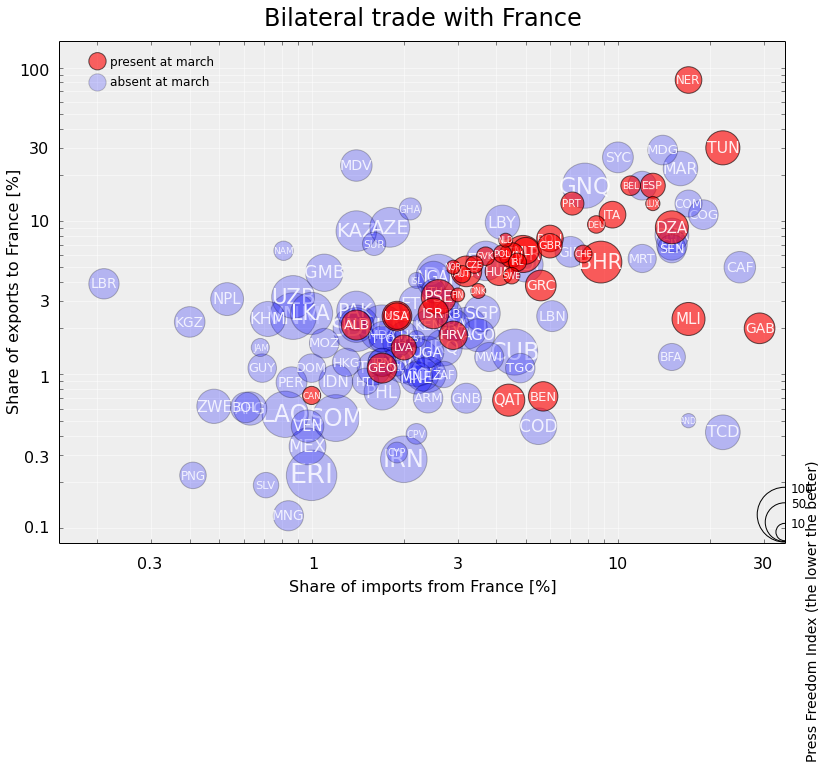

In [165]:
fig, ax = plt.subplots(1,1,subplot_kw=dict(axisbg='#EEEEEE'),figsize=(13,9))   
ax.grid(color='white', linestyle='solid')

#set manual labels [waiting for MPLD3 support]
ax.yaxis.set_major_formatter(plt.NullFormatter())
ylabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
ax.set_yticks(np.log10(ylabels))
ax.xaxis.set_major_formatter(plt.NullFormatter())
xlabels=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30]
ax.set_xticks(np.log10(xlabels))

ax.set_ylim(np.log10([0.08,150]))
ax.set_xlim(np.log10([0.15,35]))

ax.text(0.125,-0.05,0.3,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
ax.text(0.35,-0.05,1,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
ax.text(0.55,-0.05,3,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
ax.text(0.77,-0.05,10,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
ax.text(0.97,-0.05,30,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')

ax.text(-0.015,0.02,0.1,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.16,0.3,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.32,1,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.47,3,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.63,10,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.775,30,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.93,100,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')

ax.set_xlabel("Share of imports from France [%]",size=16,labelpad=33)
ax.set_ylabel("Share of exports to France [%]",size=16,labelpad=33)
ax.text(0.5,1.03,'Bilateral trade with France',horizontalalignment='center',transform=ax.transAxes,size=24,color='k')

for i in a:
    if i=='France': continue
    if a[i]['import']<0.1: continue
    else: x=np.log10(a[i]['import'])
    if a[i]['export']<0.1: continue
    else: y=np.log10(a[i]['export'])
    s=a[i]['press']
    if a[i]['head']: 
        p=0.6
        c='r'
        z=2000-s
    else: 
        p=0.2
        c='b'
        z=1000-s
    
    plt.scatter(x,y,s*30,c=c,alpha=p,zorder=z)
    ax.text(x,y,a[i]['code'],horizontalalignment='center',verticalalignment='center',size=6+s/4,color='w',zorder=z+1)
    scatter=plt.scatter(x,y,s*30,c=c,alpha=0.05,zorder=z+2)
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=[i])
    mpld3.plugins.connect(fig, tooltip)
    
plt.scatter(np.log10(35),np.log10(0.122),100*30,c='k',facecolor='none',zorder=2010)
plt.scatter(np.log10(35),np.log10(0.109),50*30,c='k',facecolor='none',zorder=2010)
plt.scatter(np.log10(35),np.log10(0.094),10*30,c='k',facecolor='none',zorder=2010)
ax.text(1.01,0.03,10,horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(1.01,0.07,50,horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(1.01,0.1,100,horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(1.03,0.14,'Press Freedom Index (the lower the better)',horizontalalignment='left',rotation=90,transform=ax.transAxes,size=14,color='k')

plt.scatter(np.log10(0.2),np.log10(110),10*30,c='r',zorder=2010,alpha=0.6)
plt.scatter(np.log10(0.2),np.log10(80),10*30,c='b',zorder=2010,alpha=0.2)
ax.text(0.07,0.95,'present at march',horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(0.07,0.91,'absent at march',horizontalalignment='left',transform=ax.transAxes,size=12,color='k')

plt.show()

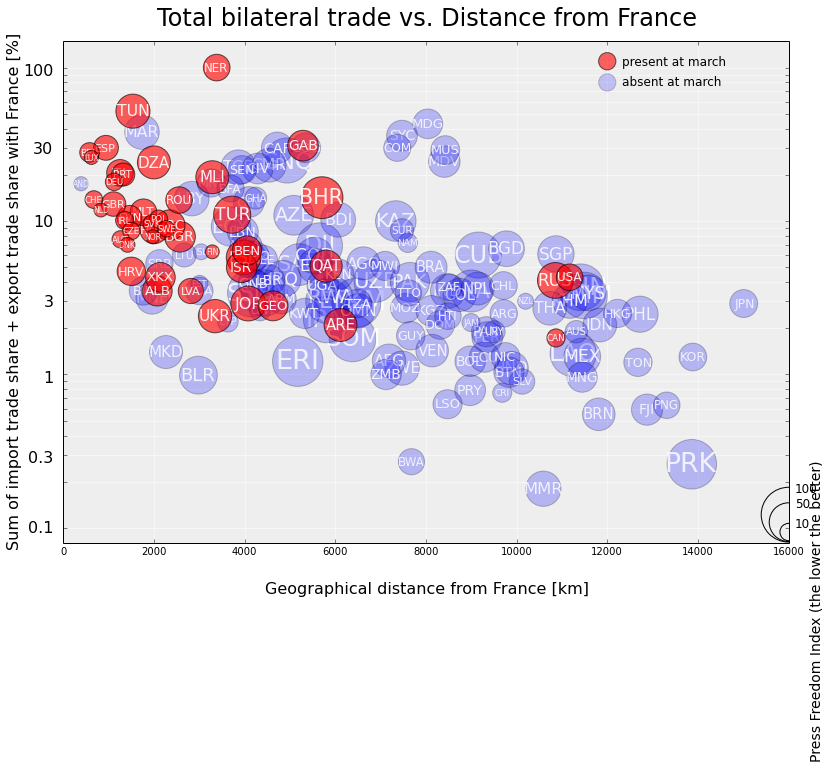

In [151]:
fig, ax = plt.subplots(1,1,subplot_kw=dict(axisbg='#EEEEEE'),figsize=(13,9))   
ax.grid(color='white', linestyle='solid')

#set manual labels [waiting for MPLD3 support]
ax.yaxis.set_major_formatter(plt.NullFormatter())
ylabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
ax.set_yticks(np.log10(ylabels))
#ax.xaxis.set_major_formatter(plt.NullFormatter())
#xlabels=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30]
#ax.set_xticks(np.log10(xlabels))

ax.set_ylim(np.log10([0.08,150]))
ax.set_xlim([0,16000])

#ax.text(0.125,-0.05,0.3,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.35,-0.05,1,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.55,-0.05,3,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.77,-0.05,10,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.97,-0.05,30,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')

ax.text(-0.015,0.02,0.1,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.16,0.3,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.32,1,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.47,3,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.63,10,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.775,30,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')
ax.text(-0.015,0.93,100,horizontalalignment='right',transform=ax.transAxes,size=16,color='k')

ax.set_xlabel("Geographical distance from France [km]",size=16,labelpad=25)
ax.set_ylabel("Sum of import trade share + export trade share with France [%]",size=16,labelpad=37)
ax.text(0.5,1.03,'Total bilateral trade vs. Distance from France ',horizontalalignment='center',transform=ax.transAxes,size=24,color='k')

for i in a:
    if i=='France': continue
    if a[i]['import']+a[i]['export']<0.1: continue
    else: y=np.log10(a[i]['import']+a[i]['export'])
    x=a[i]['dist']
    s=a[i]['press']
    if a[i]['head']: 
        p=0.6
        c='r'
        z=2000-s
    else: 
        p=0.2
        c='b'
        z=1000-s
    
    plt.scatter(x,y,s*30,c=c,alpha=p,zorder=z)
    ax.text(x,y,a[i]['code'],horizontalalignment='center',verticalalignment='center',size=6+s/4,color='w',zorder=z+1)
    scatter=plt.scatter(x,y,s*30,c=c,alpha=0.05,zorder=z+2)
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=[i])
    mpld3.plugins.connect(fig, tooltip)
    
plt.scatter(16000,np.log10(0.122),100*30,c='k',facecolor='none',zorder=2010)
plt.scatter(16000,np.log10(0.109),50*30,c='k',facecolor='none',zorder=2010)
plt.scatter(16000,np.log10(0.094),10*30,c='k',facecolor='none',zorder=2010)
ax.text(1.01,0.03,10,horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(1.01,0.07,50,horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(1.01,0.1,100,horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(1.03,0.14,'Press Freedom Index (the lower the better)',horizontalalignment='left',rotation=90,transform=ax.transAxes,size=14,color='k')

plt.scatter(12000,np.log10(110),10*30,c='r',zorder=2010,alpha=0.6)
plt.scatter(12000,np.log10(80),10*30,c='b',zorder=2010,alpha=0.2)
ax.text(0.77,0.95,'present at march',horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(0.77,0.91,'absent at march',horizontalalignment='left',transform=ax.transAxes,size=12,color='k')

plt.show()

In [166]:
#switch back to mpl, disable mpld3
import matplotlib.pyplot as plt
%matplotlib inline

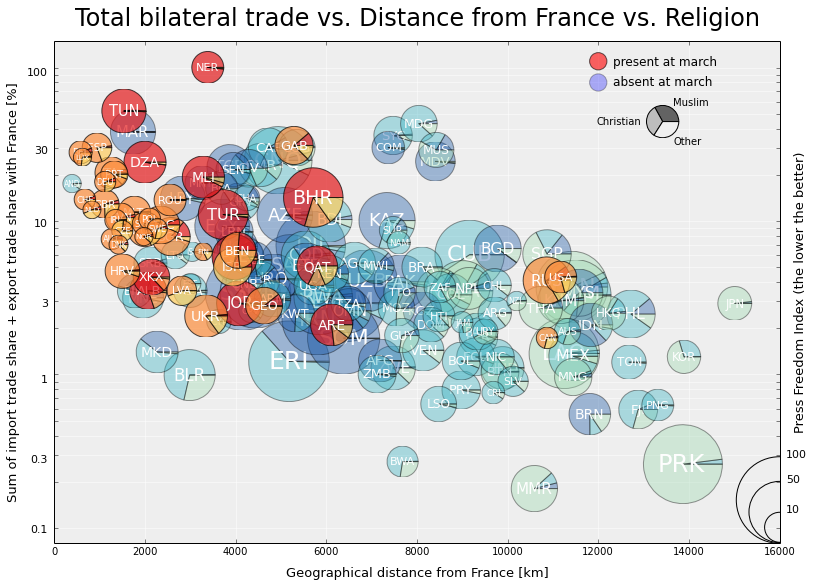

In [185]:
fig, ax = plt.subplots(1,1,subplot_kw=dict(axisbg='#EEEEEE'),figsize=(13,9))   
ax.grid(color='white', linestyle='solid')

#set manual labels [waiting for MPLD3 support]
ax.yaxis.set_major_formatter(plt.NullFormatter())
ylabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
ax.set_yticks(np.log10(ylabels))
#ax.xaxis.set_major_formatter(plt.NullFormatter())
#xlabels=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30]
#ax.set_xticks(np.log10(xlabels))

ylims=np.log10([0.08,150])
xlims=[0,16000]
ax.set_ylim(ylims)
ax.set_xlim(xlims)

#ax.text(0.125,-0.05,0.3,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.35,-0.05,1,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.55,-0.05,3,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.77,-0.05,10,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')
#ax.text(0.97,-0.05,30,horizontalalignment='center',transform=ax.transAxes,size=16,color='k')

ax.text(-0.01,0.02,0.1,horizontalalignment='right',transform=ax.transAxes,size=11,color='k')
ax.text(-0.01,0.16,0.3,horizontalalignment='right',transform=ax.transAxes,size=11,color='k')
ax.text(-0.01,0.32,1,horizontalalignment='right',transform=ax.transAxes,size=11,color='k')
ax.text(-0.01,0.47,3,horizontalalignment='right',transform=ax.transAxes,size=11,color='k')
ax.text(-0.01,0.63,10,horizontalalignment='right',transform=ax.transAxes,size=11,color='k')
ax.text(-0.01,0.775,30,horizontalalignment='right',transform=ax.transAxes,size=11,color='k')
ax.text(-0.01,0.93,100,horizontalalignment='right',transform=ax.transAxes,size=11,color='k')

ax.set_xlabel("Geographical distance from France [km]",size=13,labelpad=10)
ax.set_ylabel("Sum of import trade share + export trade share with France [%]",size=13,labelpad=30)
ax.text(0.5,1.03,'Total bilateral trade vs. Distance from France vs. Religion',horizontalalignment='center',transform=ax.transAxes,size=24,color='k')


#sort dictionary based on press index (large points go to the bottom)
b=[]
for i in range(len(a.keys())):
    if a[a.keys()[i]]['head']: b.append(-a[a.keys()[i]]['press']+100)
    else: b.append(-a[a.keys()[i]]['press'])
ind=np.argsort(b)

for k in ind:
    i=a.keys()[k]
    if i=='France': continue
    if a[i]['import']+a[i]['export']<0.1: continue
    else: y=np.log10(a[i]['import']+a[i]['export'])
    x=a[i]['dist']
    s=a[i]['press']
    if a[i]['head']: 
        p=0.7
        c=[[227/255.0,26/255.0,28/255.0,p],[253/255.0,141/255.0,60/255.0,p],[254/255.0,204/255.0,92/255.0,p]]
        z=2000-s
        c2='w'
    else: 
        p=0.4
        c=[[34/255.0,94/255.0,168/255.0,p],[65/255.0,182/255.0,196/255.0,p],[161/255.0,218/255.0,180/255.0,p]]
        z=1000-s
        c2='w'
    ax2 = fig.add_axes([0.125+x/(xlims[1]-xlims[0])*0.775-s/1600-0.01, 0.385+y/(ylims[1]-ylims[0])*0.775-s/1600-0.01, \
                        0.02+s/800, 0.02+s/800])
    wedges, texts = ax2.pie([a[i]['Muslim'],a[i]['Christian'],100-(a[i]['Muslim']+a[i]['Christian'])],colors=c)
    for w in wedges:
        w.set_linewidth(1)
        w.set_edgecolor([0,0,0,p])
    ax2.axis('equal')
    ax2.axis('off')
    ax2.text(0,0,a[i]['code'],horizontalalignment='center',verticalalignment='center',size=6+s/4.5,color=c2)
    
ax.scatter(16000,np.log10(0.152),250*30,c='k',facecolor='none',zorder=2010)
ax.scatter(16000,np.log10(0.127),125*30,c='k',facecolor='none',zorder=2010)
ax.scatter(16000,np.log10(0.101),30*30,c='k',facecolor='none',zorder=2010)
ax.text(1.01,0.06,10,horizontalalignment='left',transform=ax.transAxes,size=11,color='k')
ax.text(1.01,0.12,50,horizontalalignment='left',transform=ax.transAxes,size=11,color='k')
ax.text(1.01,0.17,100,horizontalalignment='left',transform=ax.transAxes,size=11,color='k')
ax.text(1.02,0.22,'Press Freedom Index (the lower the better)',horizontalalignment='left',verticalalignment='bottom',rotation=90,transform=ax.transAxes,size=13,color='k')

ax.scatter(12000,np.log10(110),10*30,c='r',zorder=2010,alpha=0.6)
ax.scatter(12000,np.log10(80),10*30,c='b',zorder=2010,alpha=0.3)
ax.text(0.77,0.95,'present at march',horizontalalignment='left',transform=ax.transAxes,size=12,color='k')
ax.text(0.77,0.91,'absent at march',horizontalalignment='left',transform=ax.transAxes,size=12,color='k')

c=['#636363','#bdbdbd','#f0f0f0']
l=['Muslim','Christian','Other']
ax2 = fig.add_axes([0.75,0.75,0.05,0.05])
ax2.pie([0.33,0.33,0.34],colors=c,labels=l,labeldistance=1.4)
ax2.axis('equal')
ax2.axis('off')

plt.show()